In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import shapiro, anderson, t

In [3]:
df_general = pd.read_excel('/Users/kassywang/Documents/Summer Project/abpm_general_cohort_data.xlsx')
df_vicinity = pd.read_excel('/Users/kassywang/Documents/Summer Project/abpm_vicinity_matching_data.xlsx')

In [4]:
for df in (df_general, df_vicinity):
    df['timestamp'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), dayfirst=True, errors='coerce')
    df[['systolic', 'diastolic']] = df['bp_mm_hg'].str.split('/', expand=True)
    df['systolic'] = pd.to_numeric(df['systolic'], errors='coerce')

df_all = pd.concat([df_general, df_vicinity], ignore_index=True)
df_all.dropna(subset=['study_id', 'timestamp', 'systolic'], inplace=True)

df_all['hour'] = df_all['timestamp'].dt.hour
df_all['day_period'] = df_all['hour'].apply(lambda h: 'night' if h < 7 or h >= 22 else 'day')
df_all["clock_float"] = df_all["timestamp"].dt.hour + df_all["timestamp"].dt.minute / 60 + df_all["timestamp"].dt.second / 3600
df_all["first_date"] = df_all.groupby("study_id")["timestamp"].transform(lambda ts: ts.dt.date.min())
df_all["day_index"] = (df_all["timestamp"].dt.date != df_all["first_date"]).astype(int)
df_all["continuous_time"] = df_all["day_index"] * 24 + df_all["clock_float"]


In [5]:
df_counts = df_all.groupby("study_id")["day_period"].value_counts().unstack(fill_value=0)
df_counts["good"] = (df_counts["day"] >= 3) & (df_counts["night"] >= 3)
good_ids = set(df_counts[df_counts["good"]].index)
df_good = df_all[df_all["study_id"].isin(good_ids)].copy()

In [6]:
n_good = df_counts["good"].sum()
n_not_good = (~df_counts["good"]).sum()

print(f"Number of good patients: {n_good}")
print(f"Number of non-good patients: {n_not_good}")

Number of good patients: 714
Number of non-good patients: 107


In [7]:
ratio_before = (
    df_good.groupby(['study_id', 'day_period'])['systolic']
    .mean().unstack().dropna()
    .rename(columns={'day': 'day_mean', 'night': 'night_mean'})
)
# (night - day )/day: dipper(-0.2, -0.1); extreme dipper(<-0.2); non dipper(-0.1, 0); reverse dipper(>0)
ratio_before['day_night_ratio'] = (ratio_before['night_mean'] - ratio_before['day_mean']) / ratio_before['day_mean']
ratio_before.reset_index(inplace=True)

In [8]:
def classify_dipper(ratio):
    if ratio < -0.2:
        return "Extreme Dipper"
    elif -0.2 <= ratio < -0.1:
        return "Dipper"
    elif -0.1 <= ratio <= 0:
        return "Non-dipper"
    else:
        return "Reverse Dipper"


In [9]:
ratio_before["calculated_classification"] = ratio_before['day_night_ratio'].apply(classify_dipper)

all_categories = sorted(ratio_before["calculated_classification"].dropna().unique())

print(all_categories)



['Dipper', 'Extreme Dipper', 'Non-dipper', 'Reverse Dipper']


In [10]:
df_good = df_good.merge(
    ratio_before[["study_id", "calculated_classification"]]
    .rename(columns={"calculated_classification": "classification_before"}),
    on="study_id",
    how="left",
    
)
before_classification = df_good.drop_duplicates(subset="study_id").reset_index(drop=True)

print(before_classification["classification_before"].value_counts())

classification_before
Non-dipper        341
Dipper            280
Reverse Dipper     55
Extreme Dipper     38
Name: count, dtype: int64


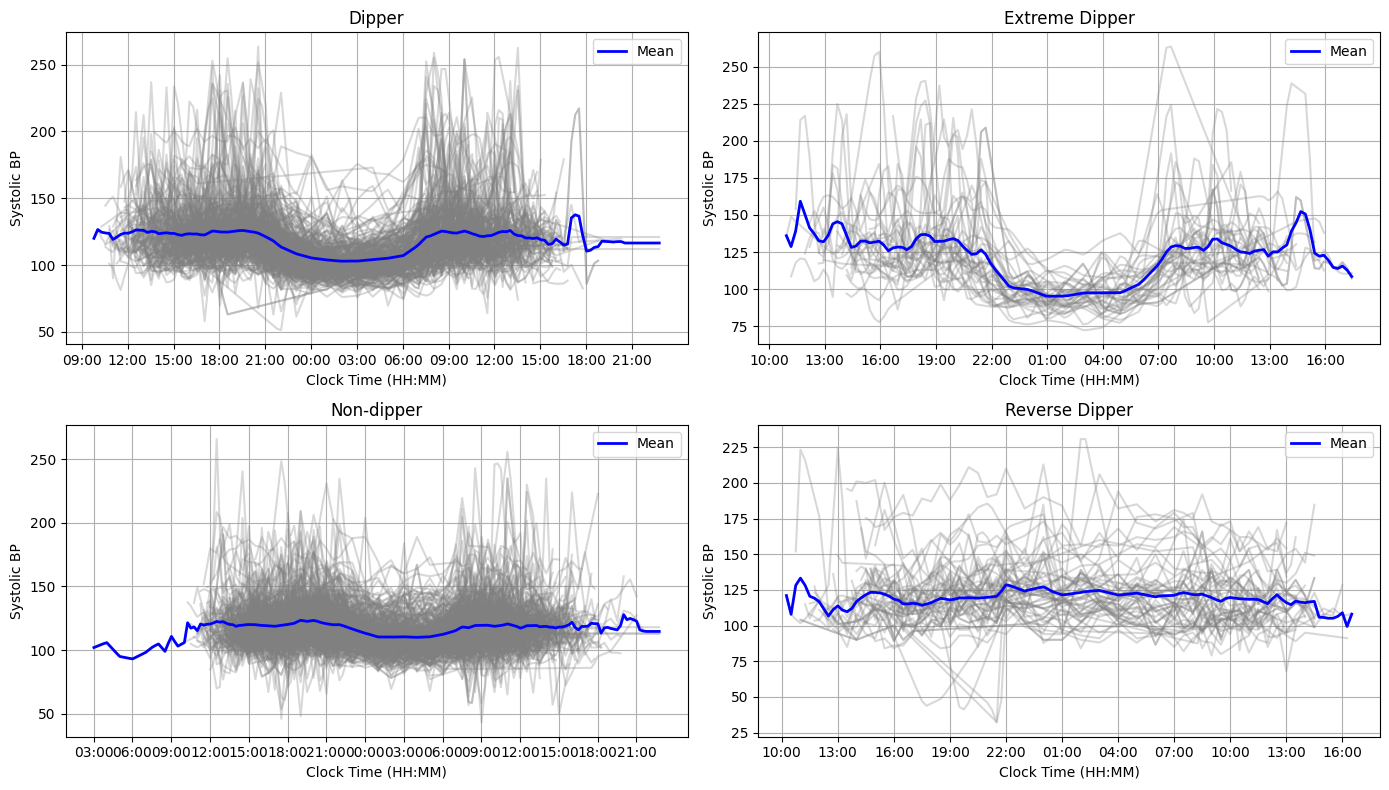

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt

n_cats = len(all_categories)
n_cols = 2
n_rows = math.ceil(n_cats / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, cat in enumerate(all_categories):
    sub = df_good[df_good["classification_before"] == cat].sort_values("timestamp")
    if sub.empty:
        axes[i].set_visible(False)
        continue

    tmin, tmax = sub.continuous_time.min(), sub.continuous_time.max()
    grid = np.arange(tmin, tmax + 1e-8, 0.25)
    curves = []

    for _, grp in sub.groupby("study_id"):
        ct = grp.continuous_time.values
        sys = grp.systolic.values
        if len(ct) < 2:
            continue
        yi = np.interp(grid, ct, sys)
        mask = (grid >= ct.min()) & (grid <= ct.max())
        yi[~mask] = np.nan
        curves.append(yi)
        axes[i].plot(grid[mask], yi[mask], color="gray", alpha=0.3)

    if curves:
        mean_curve = np.nanmean(np.vstack(curves), axis=0)
        axes[i].plot(grid, mean_curve, color="blue", linewidth=2, label="Mean")

    xticks = np.arange(math.floor(tmin), math.ceil(tmax) + 1, 3)
    xtick_labels = [f"{int(h % 24):02d}:00" for h in xticks]
    axes[i].set_xticks(xticks)
    axes[i].set_xticklabels(xtick_labels)

    axes[i].set_title(cat)
    axes[i].set_xlabel("Clock Time (HH:MM)")
    axes[i].set_ylabel("Systolic BP")
    axes[i].grid(True)
    axes[i].legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Normality Check

In [17]:
results_norm = []
results_ad = []
for pid, grp in df_all.groupby('study_id'):
    for period in ['day', 'night']:
        seg = grp[grp['day_period'] == period]['systolic']
        if len(seg) >= 3:
            stat_sw, p_sw = shapiro(seg)
            res_ad = anderson(seg, dist='norm')
            crit = res_ad.critical_values[2]  # 5% level
            sw_label = 'likely normal' if p_sw > 0.05 else 'not normal'
            ad_label = 'likely normal' if res_ad.statistic < crit else 'not normal'
        else:
            stat_sw = p_sw = crit = np.nan
     
            sw_label = ad_label = 'insufficient data'
        results_norm.append({'study_id': pid, 'period': period,
                             'shapiro_stat': stat_sw, 'shapiro_p': p_sw,
                             'shapiro_result': sw_label})
        results_ad.append({'study_id': pid, 'period': period,
                           'ad_stat': res_ad.statistic if len(seg) >= 3 else np.nan,
                           'ad_crit': crit, 'ad_result': ad_label})

norm_df = pd.DataFrame(results_norm)
ad_df = pd.DataFrame(results_ad)

In [18]:
df_all['log_systolic'] = np.where(df_all['systolic'] > 0, np.log(df_all['systolic']), np.nan)
results_log = []
for pid, grp in df_all.groupby('study_id'):
    seg = grp[grp['day_period'] == 'day']['log_systolic'].dropna()
    if len(seg) >= 3:
        stat_sw, p_sw = shapiro(seg)
        res_ad = anderson(seg, dist='norm')
        crit = res_ad.critical_values[2]
        sw = 'likely log-normal' if p_sw > 0.05 else 'not log-normal'
        ad = 'likely log-normal' if res_ad.statistic < crit else 'not log-normal'
    else:
        stat_sw = p_sw = crit = np.nan
        sw = ad = 'insufficient data'
    results_log.append({'study_id': pid,
                        'shapiro_p': p_sw, 'ad_stat': res_ad.statistic if len(seg) >= 3 else np.nan,
                        'ad_crit': crit, 'shapiro_result': sw, 'ad_result': ad})

lognorm_df = pd.DataFrame(results_log)

In [23]:
norm_summary = (
    norm_df.rename(columns={'shapiro_result': 'normality'})
    .groupby(['period', 'normality'])
    .size()
    .reset_index(name='count')
)
norm_summary['probability'] = norm_summary.groupby('period')['count'].transform(lambda x: x / x.sum())
print(norm_summary)

log_summary = (
    lognorm_df.rename(columns={'shapiro_result': 'normality'})
    .assign(period='day')  # Only day tested
    .groupby(['period', 'normality'])
    .size()
    .reset_index(name='count')
)
log_summary['probability'] = log_summary.groupby('period')['count'].transform(lambda x: x / x.sum())
print(log_summary)


  period          normality  count  probability
0    day  insufficient data     15     0.018270
1    day      likely normal    472     0.574909
2    day         not normal    334     0.406821
3  night  insufficient data    107     0.130329
4  night      likely normal    629     0.766139
5  night         not normal     85     0.103532
  period          normality  count  probability
0    day  insufficient data     15     0.018270
1    day  likely log-normal    504     0.613886
2    day     not log-normal    302     0.367844


In [12]:
small = pd.concat([ratio_before[['study_id','night_mean','day_mean']]], axis=1).dropna()


In [13]:
X = small[["day_mean"]].values
sse = {}
for g in range(1, 11):           # from 1 to 40 as minimum 20 patients in a group so 800/20 = 40
    k_total = 4 * g
    km = KMeans(n_clusters=k_total, random_state=42, n_init=10)
    km.fit(X)
    sse[g] = km.inertia_      # total SSE for k_total clusters

In [14]:
Y = small[["night_mean"]].values
sse_y = {}
for g in range(1, 11):           # from 1 to 40 as minimum 20 patients in a group so 800/20 = 40
    k_total = 4 * g
    km = KMeans(n_clusters=k_total, random_state=42, n_init=10)
    km.fit(Y)
    sse_y[g] = km.inertia_      # total SSE for k_total clusters

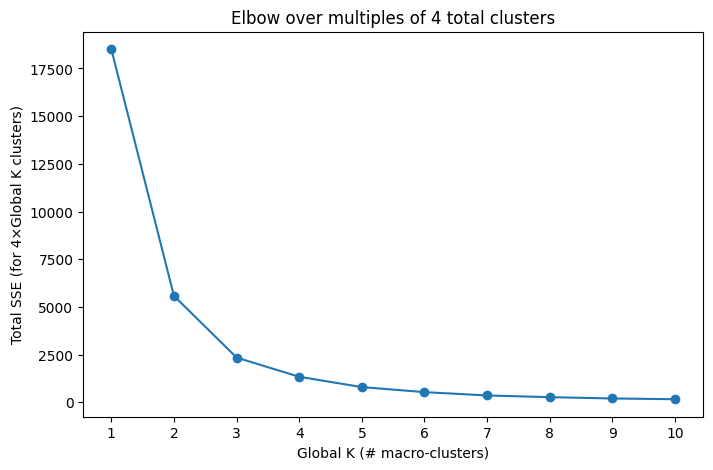

In [15]:
plt.figure(figsize=(8,5))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Global K (# macro‐clusters)")
plt.xticks(list(sse.keys()))
plt.ylabel("Total SSE (for 4×Global K clusters)")
plt.title("Elbow over multiples of 4 total clusters")
plt.show()

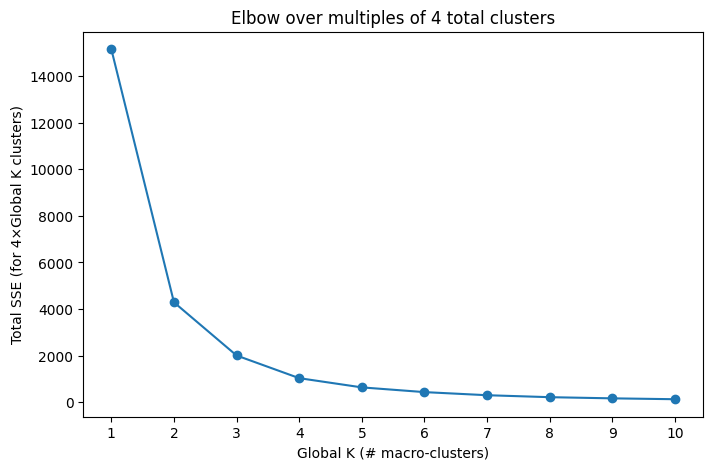

In [16]:
plt.figure(figsize=(8,5))
plt.plot(list(sse_y.keys()), list(sse_y.values()), marker='o')
plt.xlabel("Global K (# macro‐clusters)")
plt.xticks(list(sse_y.keys()))
plt.ylabel("Total SSE (for 4×Global K clusters)")
plt.title("Elbow over multiples of 4 total clusters")
plt.show()


In [17]:
k_day = KMeans(n_clusters=3, random_state=42, n_init=10)
k_night = KMeans(n_clusters=3, random_state=42, n_init=10)

small["day_group"] = k_day.fit_predict(small[["day_mean"]]) + 1
small["night_group"] = k_night.fit_predict(small[["night_mean"]]) + 1

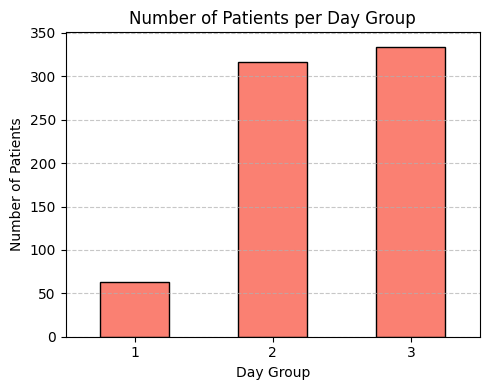

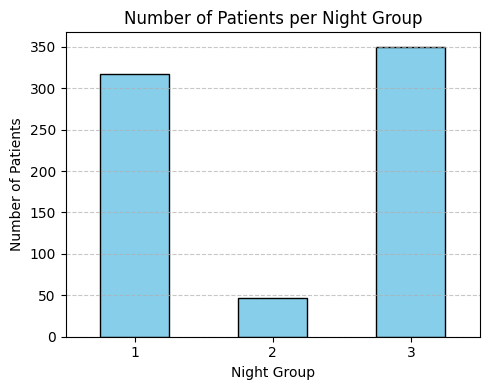

In [18]:
plt.figure(figsize=(5, 4))
small["day_group"].value_counts().sort_index().plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Number of Patients per Day Group")
plt.xlabel("Day Group")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



plt.figure(figsize=(5, 4))
small["night_group"].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Patients per Night Group")
plt.xlabel("Night Group")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [19]:
def remove_outliers(group):
    q1 = group["systolic"].quantile(0.25)
    q3 = group["systolic"].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 2 * iqr
    upper = q3 + 2 * iqr
    return group[(group["systolic"] >= lower) & (group["systolic"] <= upper)]
    

In [20]:
small = small.reset_index()  # Ensure study_id is a column, not index

df_good = df_good.merge(small[["study_id", "day_group", "night_group"]], on="study_id", how="left")


In [21]:
day = df_good[df_good["day_period"] == "day"]

night = df_good[df_good["day_period"] == "night"]

In [22]:
day_cleaned = day.groupby('day_group', group_keys=False).apply(remove_outliers)

night_cleaned = night.groupby('night_group', group_keys=False).apply(remove_outliers)

In [23]:
total_cleaned = pd.concat([day_cleaned, night_cleaned]).sort_index()


In [24]:
print("Total measurements after outlier removal:", len(day_cleaned))


Total measurements after outlier removal: 19086


In [25]:
print("Total measurements after outlier removal:", len(total_cleaned))

print("Total measurements after outlier removal:", len(df_good)-len(total_cleaned))



Total measurements after outlier removal: 25362
Total measurements after outlier removal: 544


In [26]:
ratio_after = (
    total_cleaned.groupby(['study_id', 'day_period'])['systolic']
    .mean().unstack().dropna()
    .rename(columns={'day': 'day_mean', 'night': 'night_mean'})
)



In [27]:
print(total_cleaned["day_period"].unique())


['day' 'night']


In [28]:
ratio_after['day_night_ratio'] = (
    (ratio_after['night_mean'] - ratio_after['day_mean']) / ratio_after['day_mean']
)

In [29]:
ratio_after["calculated_classification"] = ratio_after['day_night_ratio'].apply(classify_dipper)


In [30]:
after_classification = df_good.merge(
    ratio_after[["calculated_classification"]]
    .reset_index()
    .rename(columns={"calculated_classification": "classification_after"}),
    on="study_id",
    how="left"
)

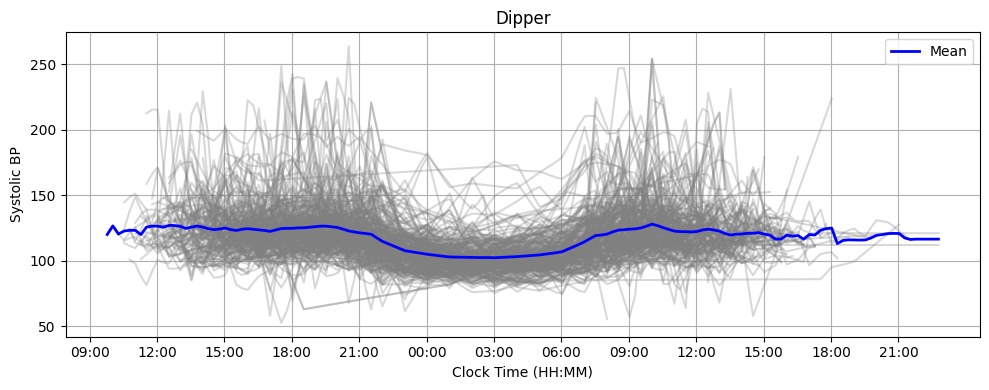

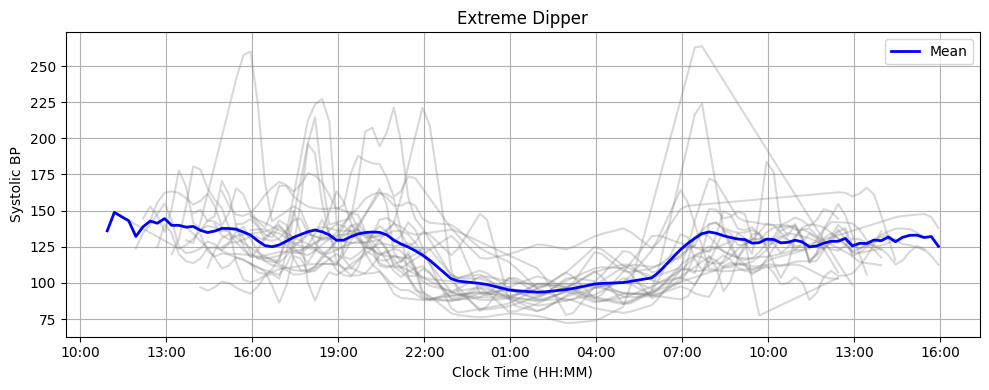

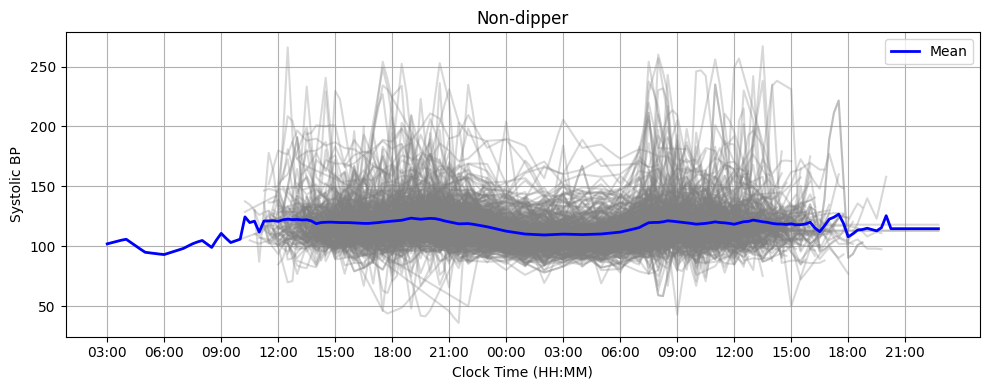

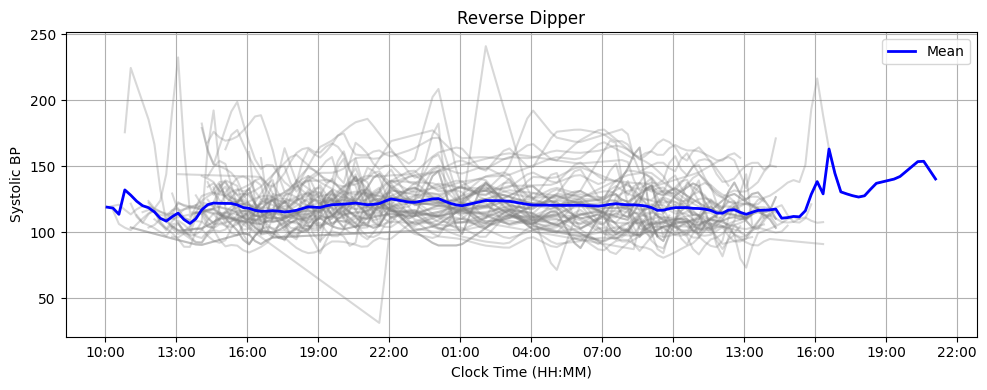

In [31]:
for cat in all_categories:
    sub = after_classification[after_classification["classification_after"] == cat].sort_values("timestamp")
    if sub.empty:
        continue

    tmin, tmax = sub.continuous_time.min(), sub.continuous_time.max()
    grid = np.arange(tmin, tmax + 1e-8, 0.25)
    curves = []

    plt.figure(figsize=(10, 4))
    for _, grp in sub.groupby("study_id"):
        ct = grp.continuous_time.values
        sys = grp.systolic.values
        if len(ct) < 2:
            continue
        yi = np.interp(grid, ct, sys)
        mask = (grid >= ct.min()) & (grid <= ct.max())
        yi[~mask] = np.nan
        curves.append(yi)
        plt.plot(grid[mask], yi[mask], color="gray", alpha=0.3)

    if curves:
        mean_curve = np.nanmean(np.vstack(curves), axis=0)
        plt.plot(grid, mean_curve, color="blue", linewidth=2, label="Mean")

    xticks = np.arange(math.floor(tmin), math.ceil(tmax) + 1, 3)
    xtick_labels = [f"{int(h % 24):02d}:00" for h in xticks]
    plt.xticks(xticks, xtick_labels)

    plt.title(cat)
    plt.xlabel("Clock Time (HH:MM)")
    plt.ylabel("Systolic BP")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [32]:
before_classification_unique = before_classification.drop_duplicates(subset="study_id")
after_classification_unique = after_classification.drop_duplicates(subset="study_id")



comparison_df = before_classification_unique.merge(after_classification_unique, on="study_id", how="inner")

category_totals = comparison_df.groupby("classification_before_x").size().rename("total_in_before_class").reset_index()
transition_counts = (
    comparison_df.groupby(["classification_before_x", "classification_after"])
    .size()
    .reset_index(name="n_patients")
    .merge(category_totals, on="classification_before_x")
)

transition_counts["percentage_within_previous_class"] = (
    transition_counts["n_patients"] / transition_counts["total_in_before_class"] * 100
).round(2)

print("Transition Summary:")
print(transition_counts.to_string(index=False))


Transition Summary:
classification_before_x classification_after  n_patients  total_in_before_class  percentage_within_previous_class
                 Dipper               Dipper         228                    280                             81.43
                 Dipper       Extreme Dipper           3                    280                              1.07
                 Dipper           Non-dipper          49                    280                             17.50
         Extreme Dipper               Dipper          18                     38                             47.37
         Extreme Dipper       Extreme Dipper          19                     38                             50.00
         Extreme Dipper           Non-dipper           1                     38                              2.63
             Non-dipper               Dipper          16                    341                              4.69
             Non-dipper           Non-dipper         317            

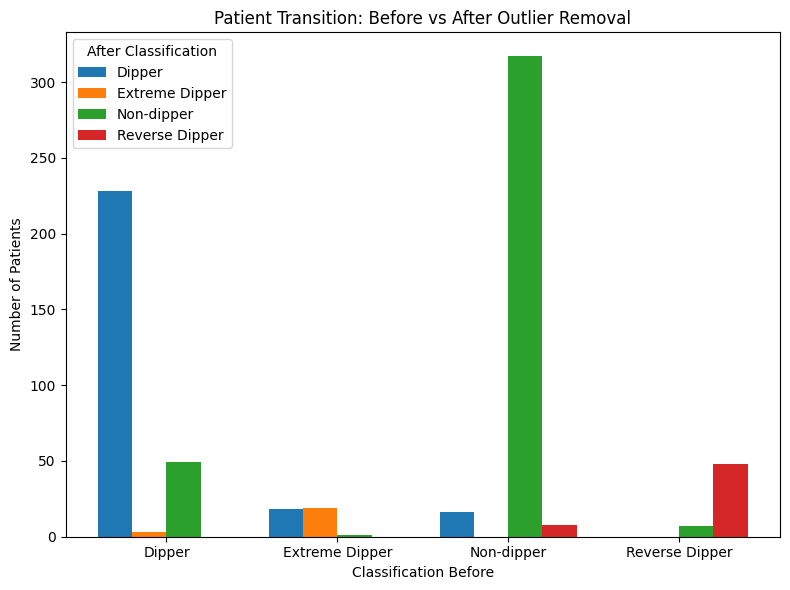

In [33]:
pivot = transition_counts.pivot(
    index='classification_before_x',
    columns='classification_after',
    values='n_patients'
)

# Build grouped bar chart
fig, ax = plt.subplots(figsize=(8, 6))
labels = pivot.index.tolist()
x = np.arange(len(labels))
n_after = pivot.shape[1]
width = 0.8 / n_after

for i, after_cat in enumerate(pivot.columns):
    ax.bar(
        x + i * width,
        pivot[after_cat].values,
        width,
        label=str(after_cat)
    )

# Axis labels & legend
ax.set_xticks(x + width * (n_after - 1) / 2)
ax.set_xticklabels(labels)
ax.set_xlabel("Classification Before")
ax.set_ylabel("Number of Patients")
ax.set_title("Patient Transition: Before vs After Outlier Removal")
ax.legend(title="After Classification")
plt.tight_layout()


In [34]:
print(ratio_before.head())
print(ratio_before.columns)


day_period    study_id    day_mean  night_mean  day_night_ratio  \
0           A007234R21  133.750000  112.444444        -0.159294   
1           A007666R21  143.347826  117.333333        -0.181478   
2           A008629R21  111.789474   89.000000        -0.203861   
3           A008823R21  119.083333   97.750000        -0.179146   
4           A009103R21  112.178571   98.444444        -0.122431   

day_period calculated_classification  
0                             Dipper  
1                             Dipper  
2                     Extreme Dipper  
3                             Dipper  
4                             Dipper  
Index(['study_id', 'day_mean', 'night_mean', 'day_night_ratio',
       'calculated_classification'],
      dtype='object', name='day_period')


In [35]:
## adding a new column in combined dataset
excel_df = pd.read_csv('/Users/kassywang/Documents/Summer Project/combined_populations_based_on_mean.csv')


excel_df.columns = excel_df.columns.str.strip().str.lower()
excel_df["study_id"] = excel_df["study_id"].astype(str)


df_all["id"] = df_all["id"].astype(str)
df_all["study_id"] = df_all["study_id"].astype(str)
total_cleaned["study_id"] = total_cleaned["study_id"].astype(str)

ratio_before_df = ratio_before.reset_index()[["study_id", "day_night_ratio"]].rename(columns={"day_night_ratio": "ratio_before"})
ratio_after_df = ratio_after.reset_index()[["study_id", "day_night_ratio"]].rename(columns={"day_night_ratio": "ratio_after"})


classification_df = (
    after_classification
    [["study_id", "classification_after"]]
    .drop_duplicates()
    .rename(columns={"classification_after": "calculated_classification"})
)


classification_df = (
    classification_df
    .merge(ratio_before_df, on="study_id", how="left")
    .merge(ratio_after_df, on="study_id", how="left")
)



id_map = df_all[["id", "study_id"]].drop_duplicates()


id_map_with_class = id_map.merge(classification_df, on="study_id", how="left")


study_id_class = classification_df.rename(columns={"study_id": "match_id"})
id_class = id_map_with_class.rename(columns={"id": "match_id"})[["match_id", "calculated_classification", "ratio_before", "ratio_after"]]


combined_class = pd.concat([study_id_class, id_class], ignore_index=True)
combined_class = combined_class.drop_duplicates(subset="match_id")


excel_df["study_id"] = excel_df["study_id"].astype(str)
final_df = excel_df.merge(combined_class, left_on="study_id", right_on="match_id", how="left")

# Save result
final_df.to_csv("final_combined_with_classification.csv", index=False)
